# Document Deskewing Using Text Bounding Boxes

- Use the angles formd by bounding boxes around text to rotate the image accordingly.
- Well suited to deskewing text documnent based images
- Resolves cases that line/image transform based approaches like Canny,Hough, etc. fail to understand
- For example, using text semantic understanding enables us to corrcet images that are perfectly flipped (180°)

In [1]:
import os
os.getpid()

11701

In [2]:
from pathlib import Path
from io import BytesIO

import numpy as np
import pandas as pd
import cv2 as cv

import PIL
from PIL import Image, ImageDraw

from google.cloud import vision

#### Load your GCP Vision API credentials here

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(Path('gcp_credentials.json'))

In [4]:
root_path = Path('data/misaligned_images/misaligned_images/')

In [5]:
sample_img = root_path / '4.jpg'
sample_img = root_path / 'law-firm-invoice-template.jpg'
# sample_img = root_path / '7.jpg'
assert sample_img.exists()

In [6]:
client = vision.ImageAnnotatorClient()

In [7]:
def make_apicall(img):
    with BytesIO() as f:
        img_bytes = img.save(f, format='jpeg')
        image = vision.Image(content=f.getvalue())
        resp = client.document_text_detection(image=image)
    return resp

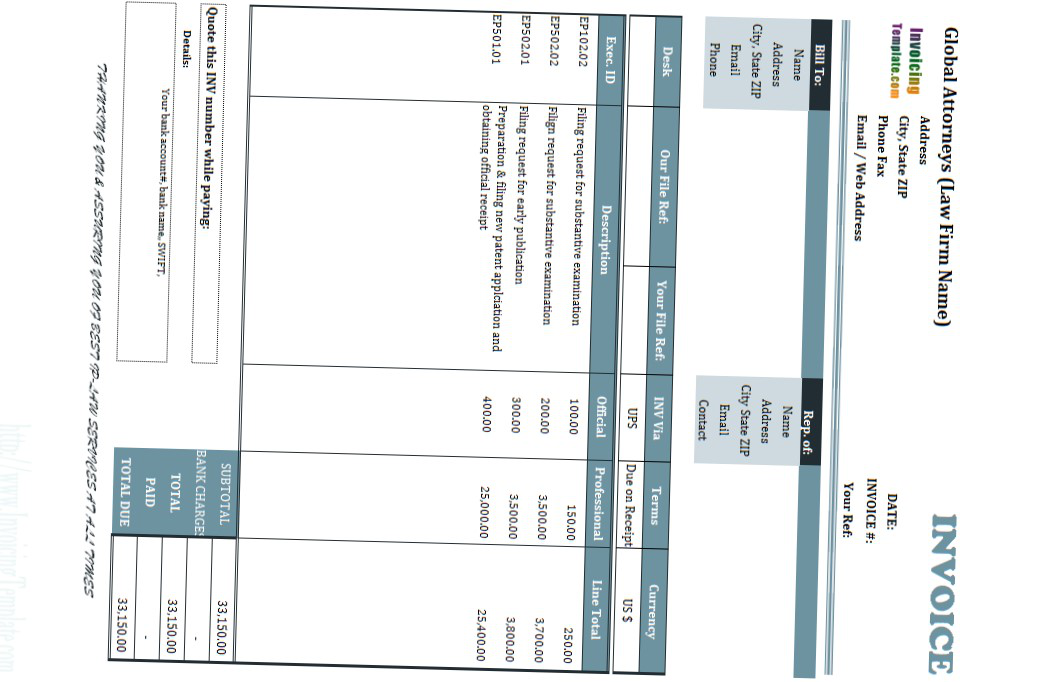

In [8]:
img = Image.open(sample_img)
img

In [9]:
%%time
resp = make_apicall(img)

CPU times: user 42.3 ms, sys: 4.87 ms, total: 47.2 ms
Wall time: 1.25 s


In [10]:
from copy import deepcopy
orig_resp = deepcopy(resp)

In [11]:
def draw_rect(orig_img, resp, annot_num=None):
    """Draw rectangles around bounding boxes given by the GCP API"""
    img = orig_img.copy()
    if annot_num is None:
        annot_nums = range(len(resp.text_annotations))
    else:
        annot_nums = [annot_num]
        
    print(len(annot_nums))
    d = ImageDraw.Draw(img)

    for anum in annot_nums:
        vertices = resp.text_annotations[anum].bounding_poly.vertices
        vertices_num = [(v.x, v.y) for v in vertices]
        assert len(vertices_num) == 4, len(vertices_num)
        
        d.polygon(vertices_num, outline='red')
        
    assert resp == orig_resp
    
    return img

157


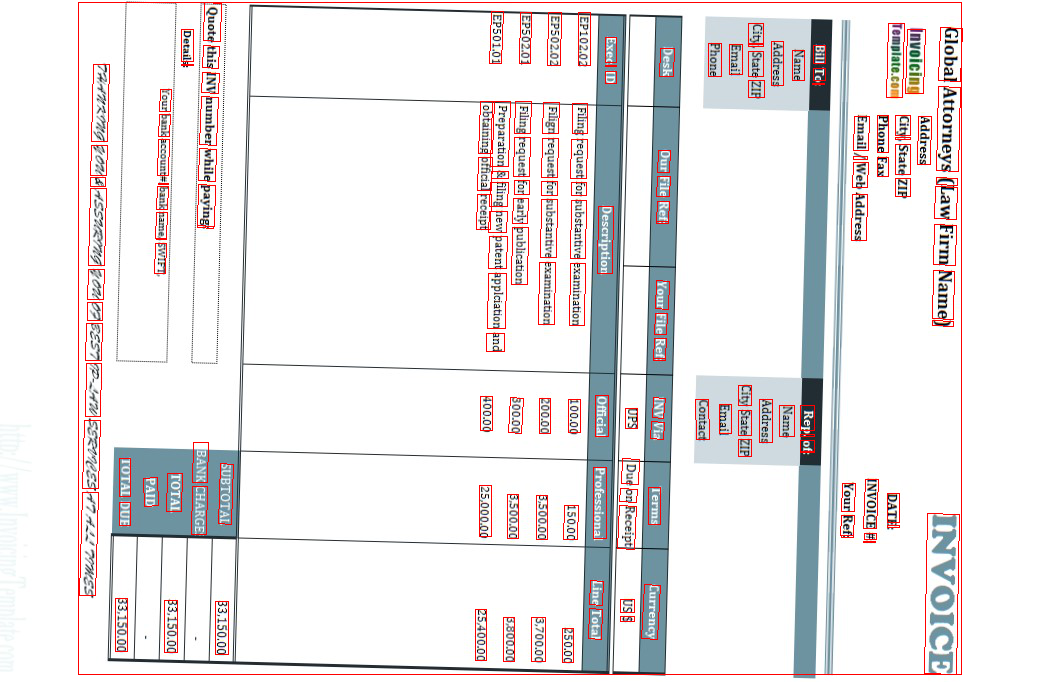

In [12]:
draw_rect(img, resp)

In [13]:
import statistics
from math import atan2, degrees
import math

def get_angle(orig_img, orig_resp, aggfn=statistics.median):
    """Calculate the angles of the upper side of the bounding boxes around text segments.
    Aggregate them into a single value using `aggfn`.
    """
    img = orig_img.copy()
    resp = deepcopy(orig_resp)
    angles = []
    
    for annot  in resp.text_annotations:
        vs = annot.bounding_poly.vertices
        assert len(vs) == 4, len(vs)
        
        # GCP returns 4 vertices in `vs`, *ordered* clockwise from the upper left corner onwards
        # we take the angles of the upper and lower parallel lines of the bounding polygon wrt the text
        # lines are directed from left -> right / up -> down
        angles.extend([
            get_angle_from_points(vs[0], vs[1]),
            get_angle_from_points(vs[3], vs[2])
        ])
        
    med_angle = aggfn(angles)
    return med_angle

def get_angle_from_points(v0, v1):
    y = v1.y - v0.y
    x = v1.x - v0.x
    angle = degrees(atan2(y, x))
    return angle

def get_distance_between_points(v0, v1):
    return math.sqrt( (v1.x-v0.x)**2 + (v1.y-v0.y)**2 )

In [14]:
%%time
img_angle = get_angle(img, resp)
img_angle

CPU times: user 11.8 ms, sys: 951 µs, total: 12.8 ms
Wall time: 12.6 ms


90.85509739626673

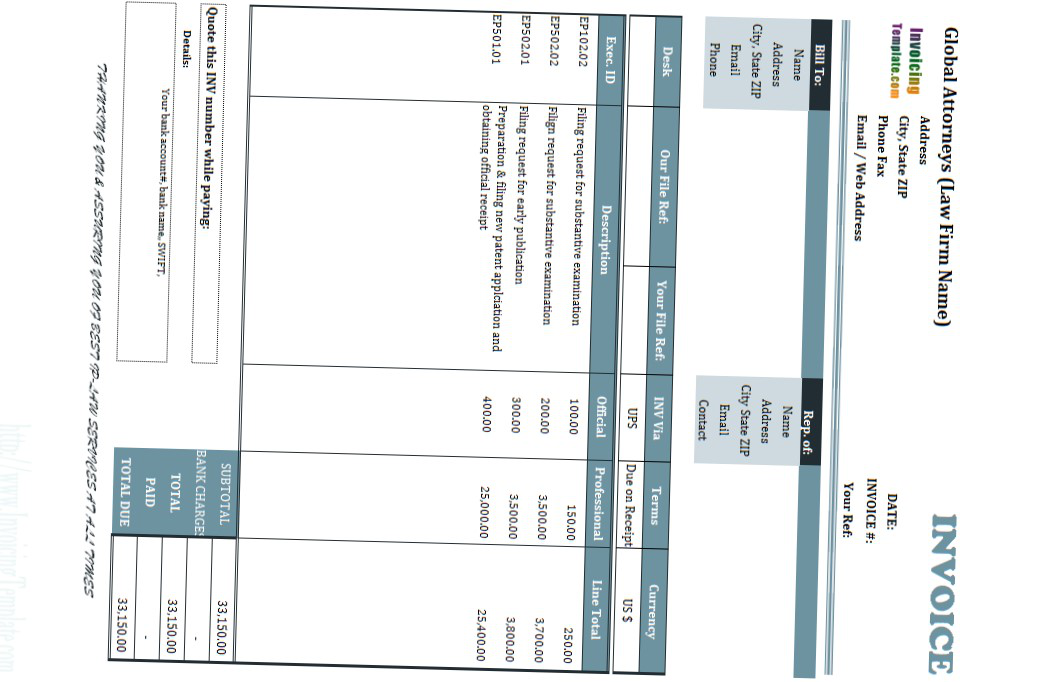

In [15]:
img

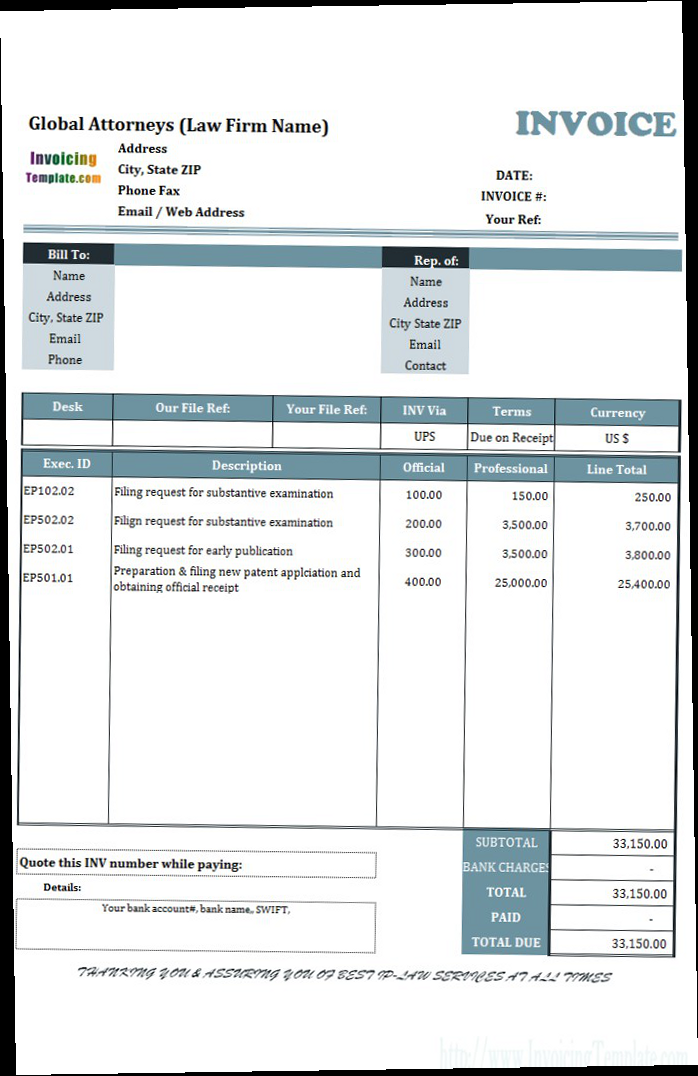

In [16]:
img.rotate(img_angle, resample=Image.BICUBIC, expand=True)

In [17]:
def add_name_to_img(img, imgname, angle):
    
    w, h = img.size
    top_size = max(50, (h // 20))
#     print(h, w, top_size)
    text = f'Image: "{imgname}" -- Angle: {angle:,.2f}°'

    out_img = Image.new("RGB", (w, h+top_size))
    out_img.paste(img, (0, top_size))
    
    d = ImageDraw.Draw(out_img)    
    font = PIL.ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", top_size-2)
    d.text((0, 0), text, font=font, fill='white')
    out_img = out_img.copy()
    out_img.thumbnail((700, 300))
    return out_img

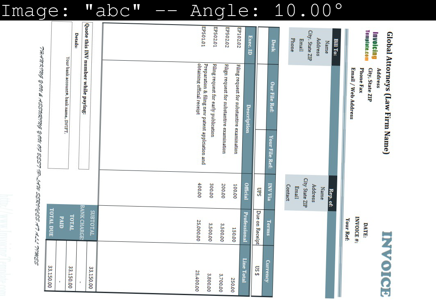

In [18]:
add_name_to_img(img, 'abc', 10)

In [19]:
def concat_images(imgs):
    widths, heights = list(zip(*(img.size for img in imgs)))
    
    out_w = sum(widths)
    out_h = max(heights)
    
    out_img = PIL.Image.new("RGB", (out_w, out_h))
    x_spos = 0
    for img in imgs:
        out_img.paste(img, (x_spos, 0))
        x_spos += img.size[0]
        
    out_img = out_img.copy()
    out_img.thumbnail((1000, 1000))
    
    return out_img

In [20]:
from IPython.display import display
def main():
    for imgpath in root_path.rglob('*'):
        img = Image.open(imgpath)
        resp = make_apicall(img)
        
        # we tried both mean and median, and found that median gave better output in most cases
        med_angle = get_angle(img, resp, aggfn=statistics.median)
#         mean_angle = get_angle(img, resp, aggfn=statistics.mean)
        
        med_img = img.rotate(med_angle, expand=True, resample=Image.BICUBIC)
        concat_img = concat_images([img, med_img])
        
        text = f'Image: "{imgpath.name}" -- Angle: {med_angle:,.2f}°'

        print(text)
        display(concat_img)
        print('-'*80)

Image: "law-firm-invoice-template.jpg" -- Angle: 90.86°


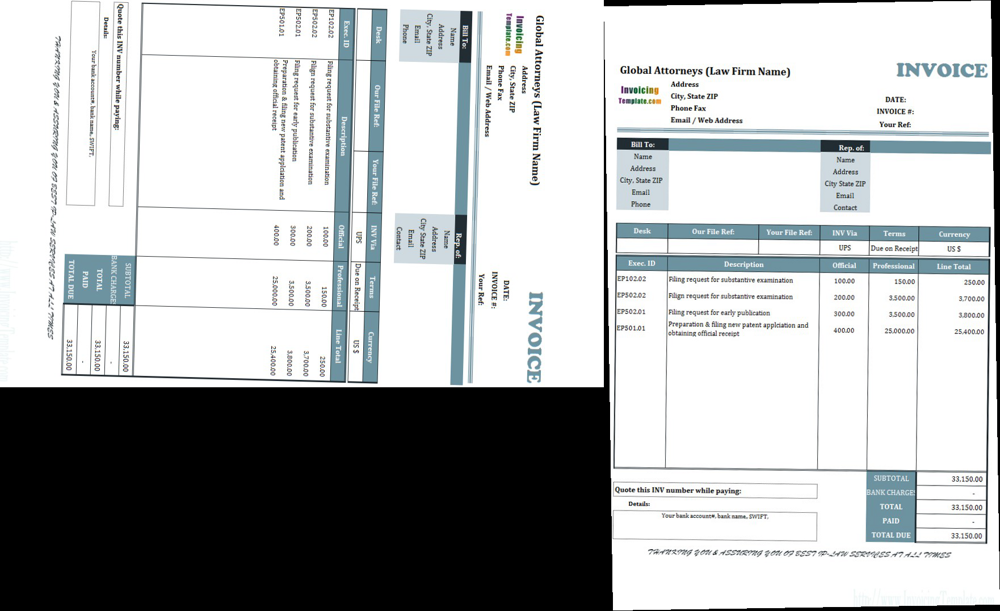

--------------------------------------------------------------------------------
Image: "0f97914844b786b0d2ef21339286cdf6 - 2.jpg" -- Angle: -2.09°


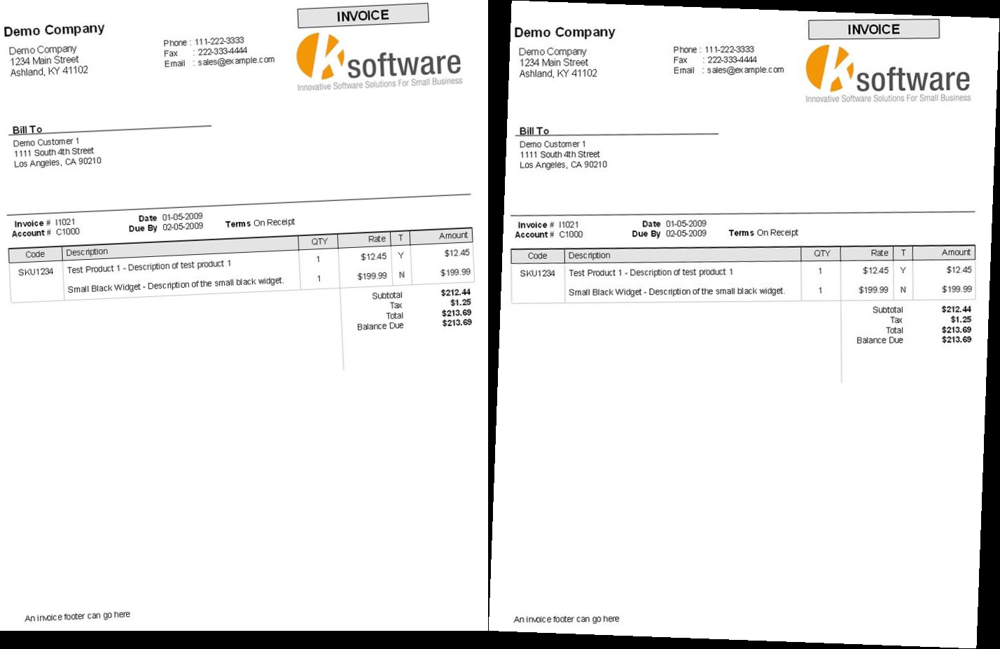

--------------------------------------------------------------------------------
Image: "10.jpg" -- Angle: 1.57°


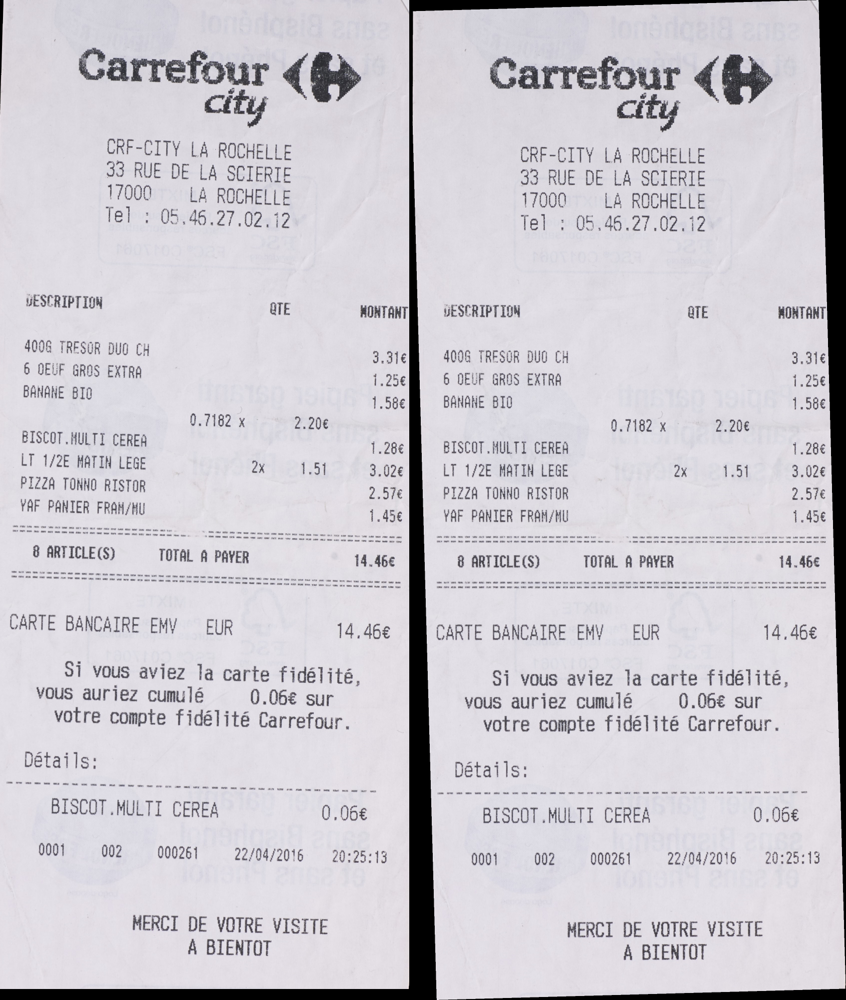

--------------------------------------------------------------------------------
Image: "6 2.jpg" -- Angle: -2.20°


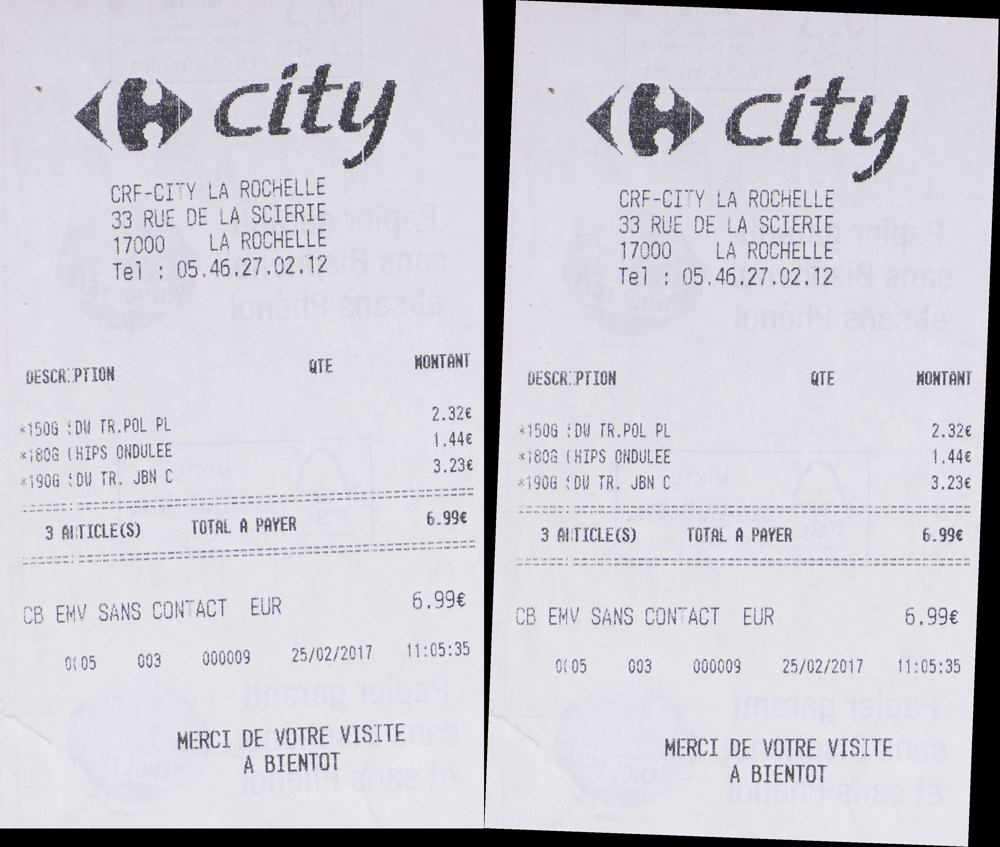

--------------------------------------------------------------------------------
Image: "5f228310d55c683ed29aa8c0adda7efc.jpg" -- Angle: 90.00°


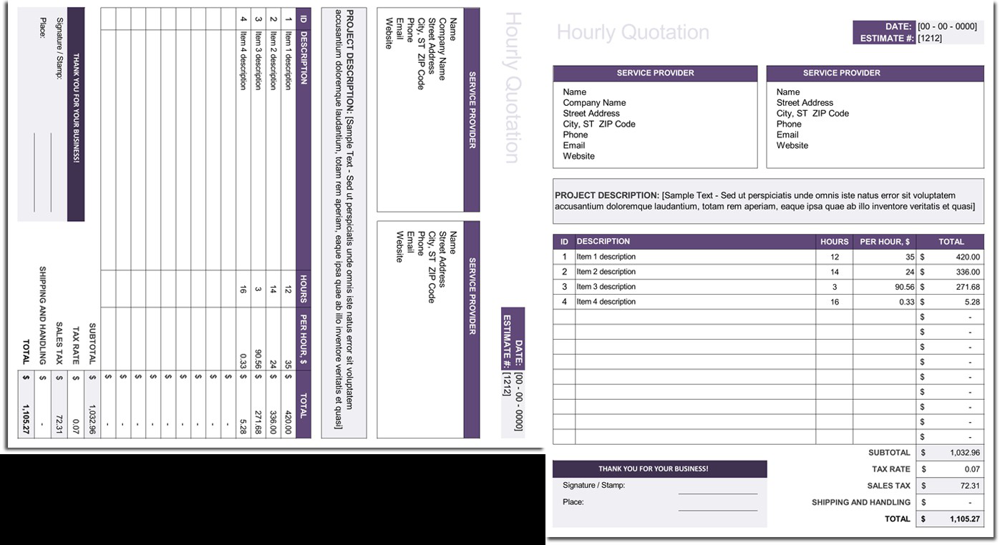

--------------------------------------------------------------------------------
Image: "AWT009.jpg" -- Angle: 1.85°


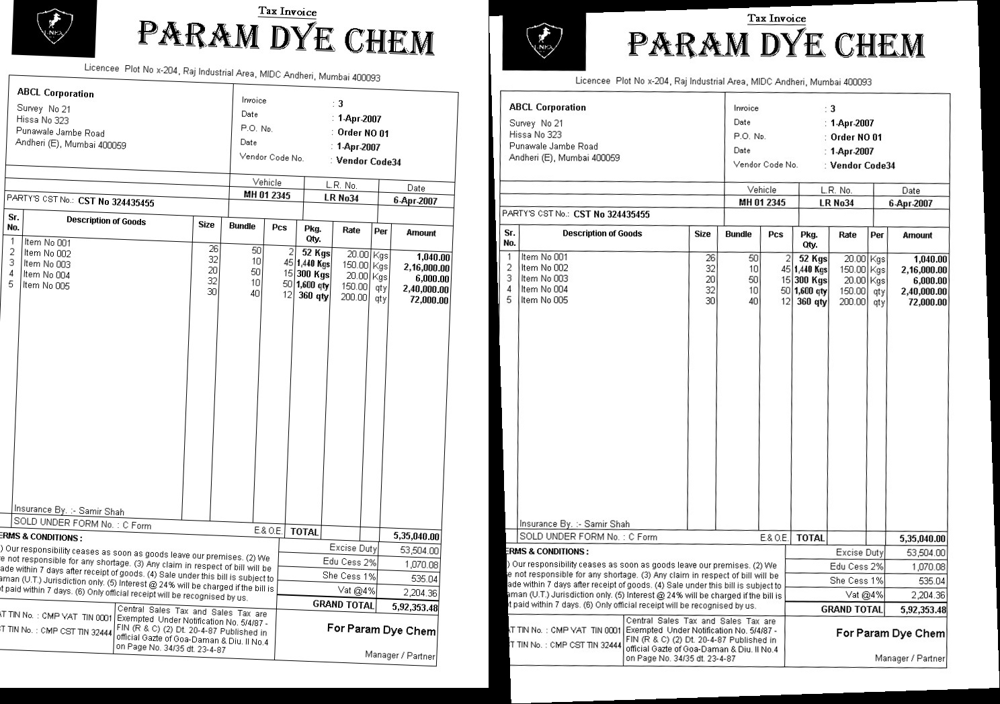

--------------------------------------------------------------------------------
Image: "4.jpg" -- Angle: 0.00°


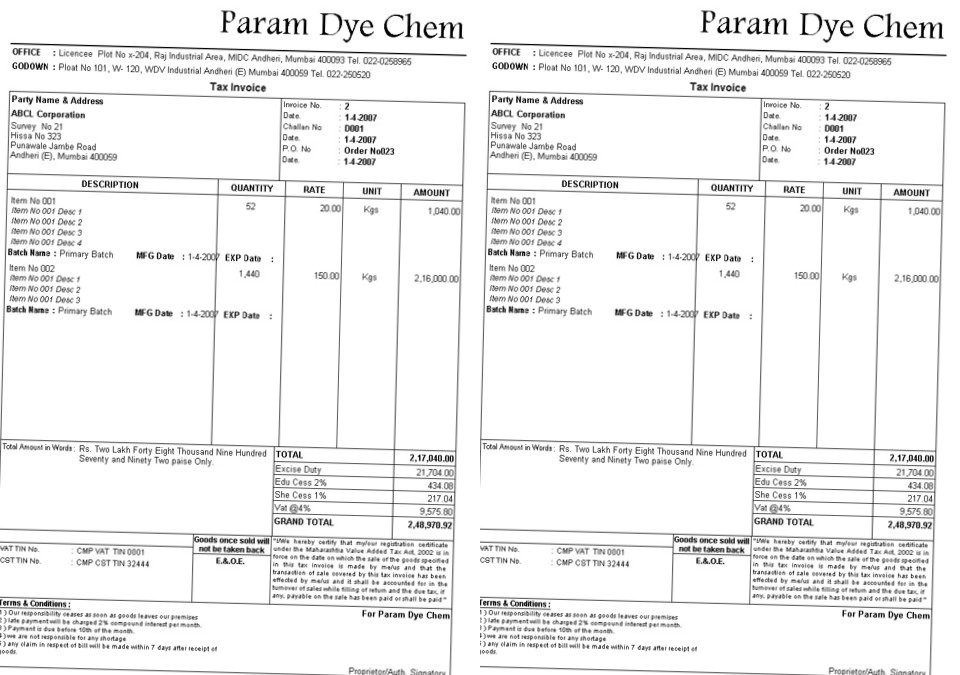

--------------------------------------------------------------------------------
Image: "billing-invoice-for-legal-services.jpg" -- Angle: -3.18°


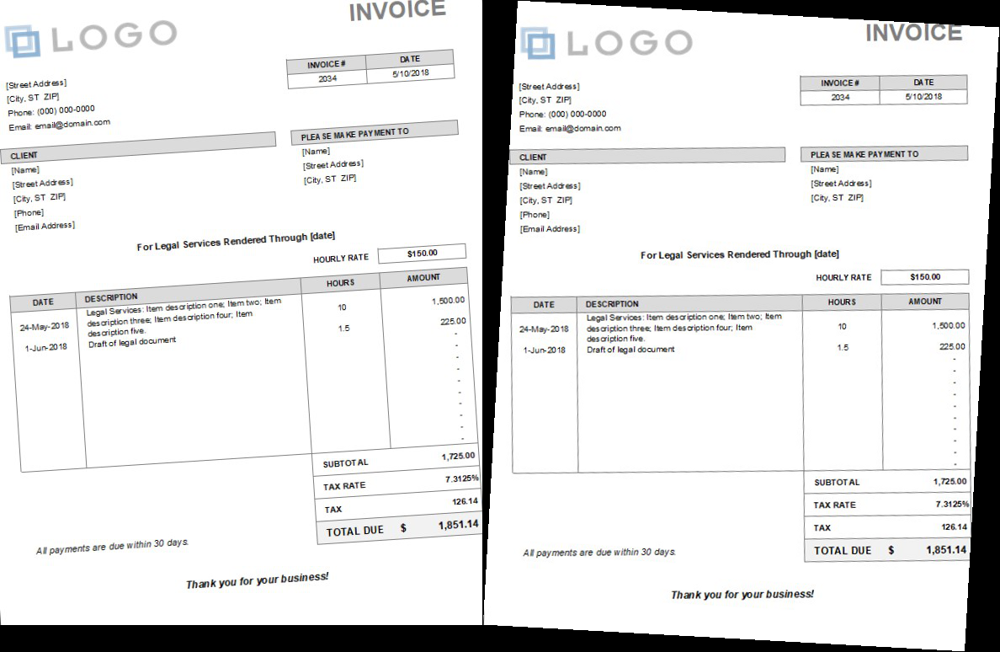

--------------------------------------------------------------------------------
Image: "5.jpg" -- Angle: -1.61°


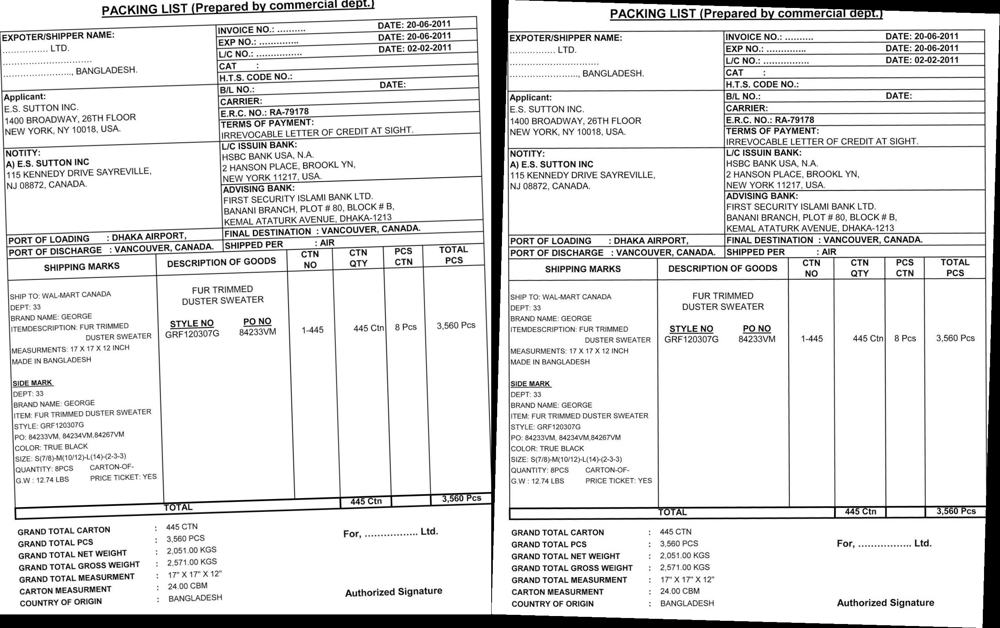

--------------------------------------------------------------------------------
Image: "7.jpg" -- Angle: 2.73°


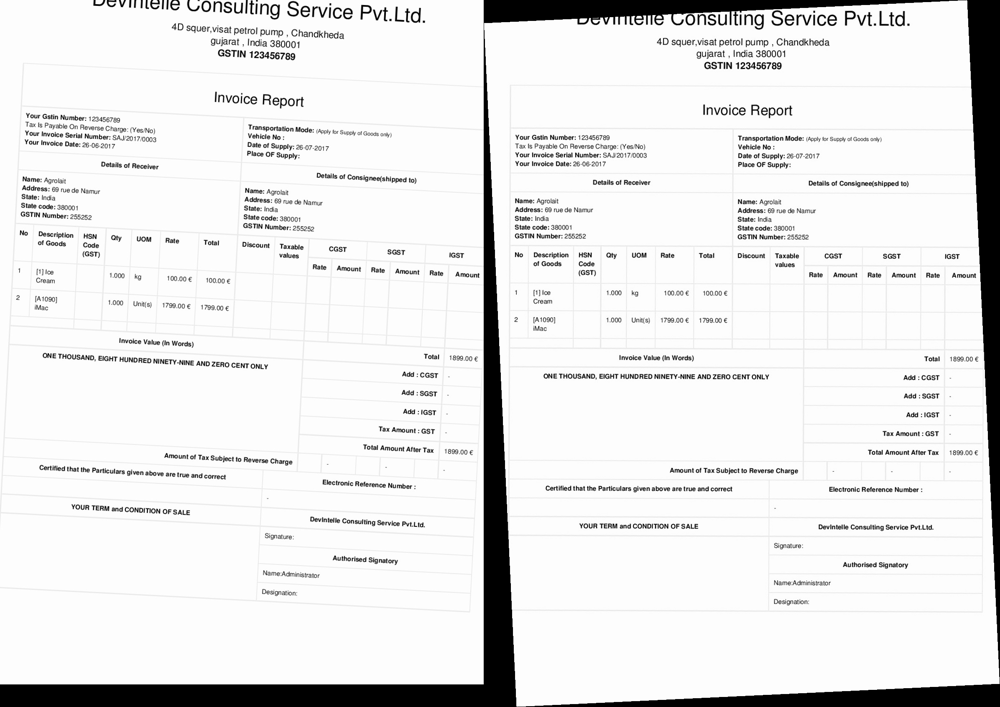

--------------------------------------------------------------------------------
Image: "41.png" -- Angle: 0.00°


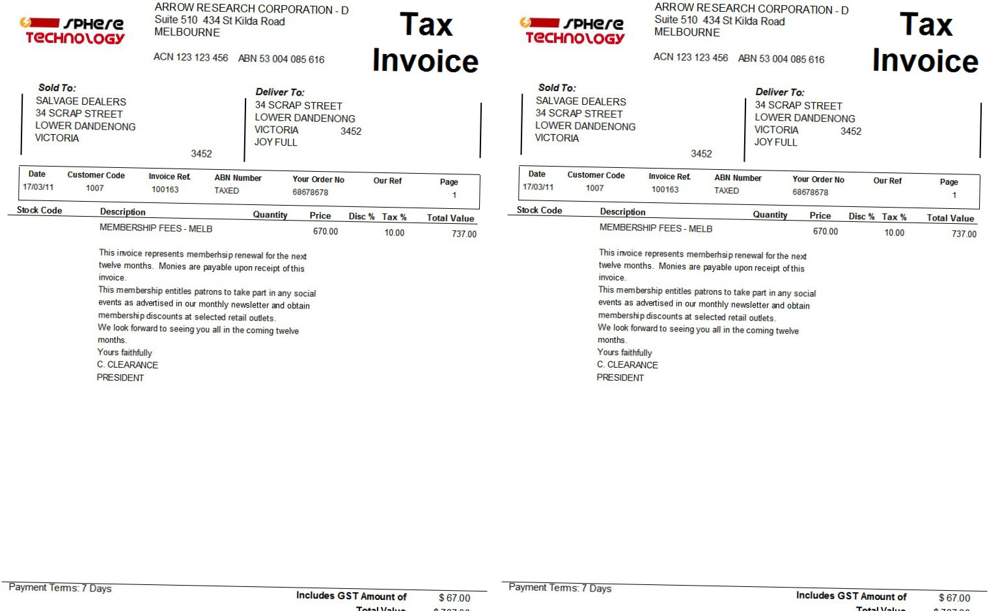

--------------------------------------------------------------------------------
Image: "6.jpg" -- Angle: -90.00°


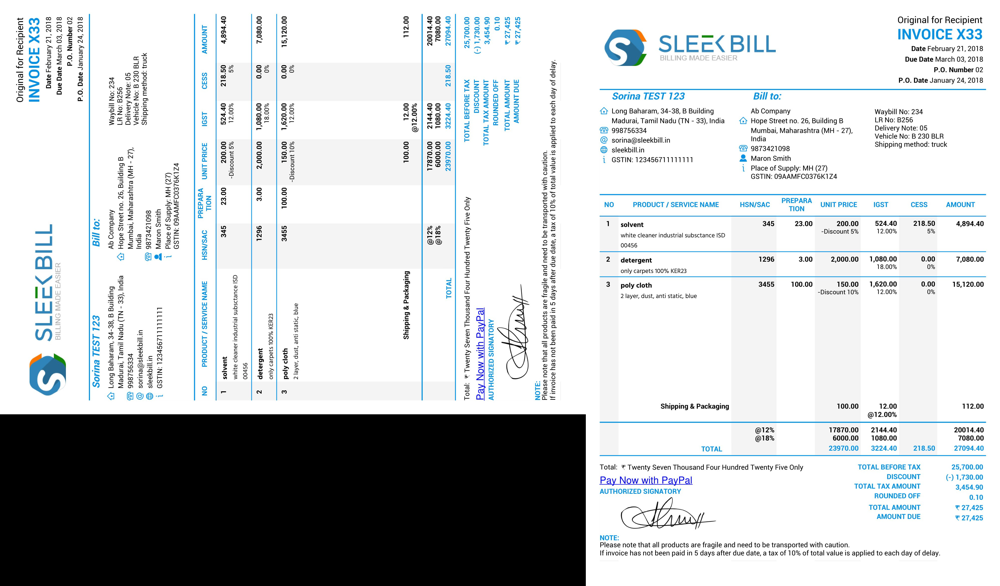

--------------------------------------------------------------------------------
Image: "0e27f636242845138158f132878a3351.jpg" -- Angle: 0.00°


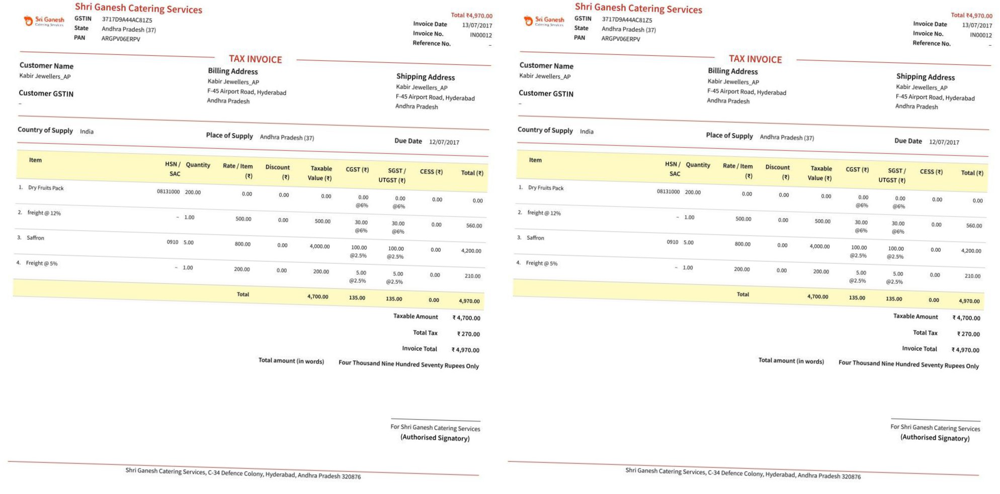

--------------------------------------------------------------------------------


In [21]:
main()